# Object Detection with SSD (Single Shot MultiBox Detector)

# This notebook demonstrates training an SSD model for object detection, specifically for car detection.
# It covers data loading, model training, evaluation, and inference.

In [28]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
# === PATH DEFINITIONS ===
import os # Import os here as it's used immediately

DRIVE_MOUNT_POINT = '/content/drive'
BASE_PROJECT_PATH = '/content/drive/MyDrive/Projects/Car Detection v2/' # MODIFY IF YOUR BASE PATH IS DIFFERENT
DATASET_BASE_PATH = os.path.join(BASE_PROJECT_PATH, 'Single Class Data') #Roboflow dataset

# Training data paths
TRAIN_IMAGES_PATH = os.path.join(DATASET_BASE_PATH, 'train/images/')
TRAIN_LABELS_PATH = os.path.join(DATASET_BASE_PATH, 'train/labels/')

# Validation data paths
VALID_IMAGES_PATH = os.path.join(DATASET_BASE_PATH, 'valid/images/')
VALID_LABELS_PATH = os.path.join(DATASET_BASE_PATH, 'valid/labels/')

# Test data path
TEST_IMAGES_DIR = os.path.join(DATASET_BASE_PATH, 'test/images') # For inference/testing

# Dataset configuration file
DATASET_YAML_PATH = os.path.join(DATASET_BASE_PATH, 'data.yaml')

# Model training output paths
MODEL_OUTPUT_BASE_PATH = os.path.join(BASE_PROJECT_PATH, 'Colab Env/Model History')
EXPERIMENT_NAME = 'singleclass_colab_YOLOv8' # Choose a descriptive name
FULL_EXPERIMENT_PATH = os.path.join(MODEL_OUTPUT_BASE_PATH, EXPERIMENT_NAME)

# Paths to specific files generated during training
BEST_WEIGHTS_PATH = os.path.join(FULL_EXPERIMENT_PATH, 'weights/best.pt')
RESULTS_CSV_PATH = os.path.join(FULL_EXPERIMENT_PATH, 'results.csv')
CONFUSION_MATRIX_IMG_PATH = os.path.join(FULL_EXPERIMENT_PATH, 'confusion_matrix.png')
# F1_CURVE_IMG_PATH = os.path.join(FULL_EXPERIMENT_PATH, 'F1_curve.png') # Example if you need other plots
# P_CURVE_IMG_PATH = os.path.join(FULL_EXPERIMENT_PATH, 'P_curve.png')
# PR_CURVE_IMG_PATH = os.path.join(FULL_EXPERIMENT_PATH, 'PR_curve.png')
# R_CURVE_IMG_PATH = os.path.join(FULL_EXPERIMENT_PATH, 'R_curve.png')

# Paths to video test
VIDEO_TEST = os.path.join(BASE_PROJECT_PATH, 'Video Test')
VIDEO_TEST_PREDICTION = os.path.join(BASE_PROJECT_PATH, 'Video Test Prediction Colab Env')

print(f"Base Project Path: {BASE_PROJECT_PATH}")
print(f"Dataset Path: {DATASET_BASE_PATH}")
print(f"Dataset YAML Path: {DATASET_YAML_PATH}")
print(f"Model Output Path: {FULL_EXPERIMENT_PATH}")
print(f"Best Weights will be saved to: {BEST_WEIGHTS_PATH}")

Base Project Path: /content/drive/MyDrive/Projects/Car Detection v2/
Dataset Path: /content/drive/MyDrive/Projects/Car Detection v2/Single Class Data
Dataset YAML Path: /content/drive/MyDrive/Projects/Car Detection v2/Single Class Data/data.yaml
Model Output Path: /content/drive/MyDrive/Projects/Car Detection v2/Colab Env/Model History/singleclass_colab_YOLOv8
Best Weights will be saved to: /content/drive/MyDrive/Projects/Car Detection v2/Colab Env/Model History/singleclass_colab_YOLOv8/weights/best.pt


In [30]:
!pip install torch torchvision opencv-python matplotlib seaborn pandas

# === System & I/O ===
import random
import glob
import json # You might need this if data.yaml maps to a JSON config for SSD

# === Data & Visualization ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg

# === Computer Vision & Model ===
import cv2
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.transforms import functional as F
from torchvision.models.detection import (
    ssd300_vgg16,
    SSD300_VGG16_Weights,
    _utils as det_utils
)
# If using MobileNetV3 as backbone for SSD, you'd combine:
from torchvision.models.detection.anchor_utils import AnchorGenerator
from torchvision.models.detection.ssd import SSDHead
from torchvision.models.detection import _utils
from torchvision.models import mobilenet_v3_large, MobileNet_V3_Large_Weights


# Configure plotting style for seaborn and matplotlib
sns.set_style('darkgrid')
%matplotlib inline

In [31]:
# Verify dataset directory
if os.path.exists(DATASET_BASE_PATH):
    print(f"Dataset directory listing for: {DATASET_BASE_PATH}")
    print(os.listdir(DATASET_BASE_PATH))
else:
    print(f"ERROR: Dataset base path not found: {DATASET_BASE_PATH}")

if os.path.exists(TRAIN_IMAGES_PATH):
    print(f"\nTrain images directory listing for: {TRAIN_IMAGES_PATH}")
    print(os.listdir(TRAIN_IMAGES_PATH)[:5]) # Print first 5 for brevity
else:
    print(f"ERROR: Train images path not found: {TRAIN_IMAGES_PATH}")

Dataset directory listing for: /content/drive/MyDrive/Projects/Car Detection v2/Single Class Data
['README.dataset.txt', 'data.yaml', 'README.roboflow.txt', '.DS_Store', 'valid', 'test', 'train']

Train images directory listing for: /content/drive/MyDrive/Projects/Car Detection v2/Single Class Data/train/images/
['screenshot_1697611055-8898516_jpg.rf.4ab0816a8d5cdbec1b93f10d04c39ed8.jpg', 'screenshot_1697681386-8348253_jpg.rf.fa840d186280e480551afe5acd0d64d3.jpg', 'screenshot_1697682787-6729238_jpg.rf.8799931f02714a887bb96e0a2cf2292d.jpg', 'frame_330_jpg.rf.80d8c478551e0efd782d500eaeb433eb.jpg', 'screenshot_1697612187-4490428_jpg.rf.7acceea23e3fee7ee953cf0d8fe90853.jpg']


In [32]:
# Count number of training images
if os.path.exists(TRAIN_IMAGES_PATH):
    train_image_files_list = os.listdir(TRAIN_IMAGES_PATH)
    number_train_files = len(train_image_files_list)
    print(f"Number of training images: {number_train_files}")
else:
    print(f"Cannot count training images, path not found: {TRAIN_IMAGES_PATH}")
    number_train_files = 0

Number of training images: 1467


In [33]:
# --- Define a custom Dataset for SSD ---
class CustomObjectDetectionDataset(Dataset):
    def __init__(self, img_dir, label_dir, transforms=None):
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.transforms = transforms
        self.image_files = [f for f in os.listdir(img_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.img_dir, img_name)
        label_name = os.path.splitext(img_name)[0] + '.txt'
        label_path = os.path.join(self.label_dir, label_name)

        img = cv2.imread(img_path)
        if img is None:
            # Handle unreadable images (e.g., return a placeholder or skip)
            print(f"Warning: Could not read image {img_path}. Skipping this item.")
            return self.__getitem__((idx + 1) % len(self)) # Load next image if current one fails

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        H, W = img.shape[0], img.shape[1]

        boxes = []
        labels = [] # Assuming 1 class for 'car'
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) == 5:
                        class_id, x_center, y_center, width, height = map(float, parts)
                        # Convert YOLO format (normalized center, width, height) to [x_min, y_min, x_max, y_max]
                        # SSD usually expects normalized [x_min, y_min, x_max, y_max]
                        x_min = (x_center - width / 2) * W
                        y_min = (y_center - height / 2) * H
                        x_max = (x_center + width / 2) * W
                        y_max = (y_center + height / 2) * H
                        boxes.append([x_min, y_min, x_max, y_max])
                        labels.append(int(class_id) + 1) # Add 1 because SSD usually treats background as class 0

        boxes_tensor = torch.as_tensor(boxes, dtype=torch.float32).reshape(-1, 4)
        labels_tensor = torch.as_tensor(labels, dtype=torch.int64)

        target = {}
        target["boxes"] = boxes_tensor
        target["labels"] = labels_tensor
        target["image_id"] = torch.tensor([idx])
        target["area"] = (boxes_tensor[:, 3] - boxes_tensor[:, 1]) * (boxes_tensor[:, 2] - boxes_tensor[:, 0])
        target["iscrowd"] = torch.zeros((len(boxes),), dtype=torch.int64)

        if self.transforms:
            img = self.transforms(img) # Convert to Tensor and normalize

        return img, target, img_path # Return img_path for display purposes

# --- Helper for plotting ---
def draw_boxes_on_image(img_rgb, boxes, labels, class_names=None):
    img = img_rgb.copy()
    for i, box in enumerate(boxes):
        x1, y1, x2, y2 = map(int, box)
        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
        if class_names and labels is not None:
            label_text = class_names[labels[i]] if labels[i] < len(class_names) else f'Class {labels[i]}'
            cv2.putText(img, label_text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    return img

# --- Main display logic ---
if number_train_files >= 16:
    # A simple transform for display: just convert to tensor
    display_transforms = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor()
    ])
    train_dataset_display = CustomObjectDetectionDataset(
        img_dir=TRAIN_IMAGES_PATH,
        label_dir=TRAIN_LABELS_PATH,
        transforms=display_transforms
    )

    # Assuming a simple class map (adjust if you have multiple classes in your data.yaml)
    # You'd typically read this from data.yaml, but for a single class, it's simpler.
    # If your class_id in labels.txt is 0 for 'car', then class_names = ['background', 'car']
    CLASS_NAMES = ['__background__', 'car'] # SSD typically uses 0 for background

    fig, axs = plt.subplots(4, 4, figsize=(16, 16))
    fig.suptitle('Sample Annotated Training Images (SSD Format)', fontsize=20)

    # Get random indices to display
    random_indices = random.sample(range(len(train_dataset_display)), 16)

    for i, idx in enumerate(random_indices):
        img_tensor, target, img_path = train_dataset_display[idx]

        # Convert tensor back to numpy for OpenCV drawing
        img_np = img_tensor.permute(1, 2, 0).numpy() # CxHxW to HxWxC
        img_np = (img_np * 255).astype(np.uint8) # Scale to 0-255

        # Draw boxes (target["boxes"] might be normalized, so you might need to scale them)
        # The CustomObjectDetectionDataset already outputs pixel coordinates, so no scaling is needed here
        annotated_img = draw_boxes_on_image(img_np, target["boxes"].tolist(), target["labels"].tolist(), CLASS_NAMES)

        ax = axs[i // 4, i % 4]
        ax.imshow(annotated_img)
        ax.set_title(os.path.basename(img_path), fontsize=8)
        ax.axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()
elif number_train_files > 0:
    print(f"Not enough training images to display 16 samples. Found {number_train_files}.")
else:
    print("No training images found to display.")

Output hidden; open in https://colab.research.google.com to view.

In [34]:
!pip install --upgrade torchvision

In [35]:
# --- Define the SSD Model with MobileNetV3 Backbone ---
import torch.nn as nn # Import the neural network module
from collections import OrderedDict # Import OrderedDict
from torchvision.models.detection.ssd import SSD
from torchvision.models.detection.anchor_utils import AnchorGenerator
from torchvision.models import mobilenet_v3_large, MobileNet_V3_Large_Weights


def create_ssd_mobilenetv3(num_classes):
    """
    Creates an SSD model with a MobileNetV3-Large backbone.

    Args:
        num_classes (int): The number of object classes (including background).
                           For 'car' + background, this would be 2.

    Returns:
        torchvision.models.detection.SSD: The SSD model.
    """
    # Load MobileNetV3 Large backbone
    # We need to adapt it to provide feature maps at multiple scales for SSD

    # Load the pretrained MobileNetV3 Large model
    backbone = mobilenet_v3_large(weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1)

    # Remove the classifier head
    backbone = backbone.features

    # Define the layers from which to extract features for SSD
    # These indices are chosen to provide feature maps at multiple spatial scales
    # Examining mobilenet_v3_large.features structure and selecting layers
    # that give different strides (approximate strides relative to input 300x300):
    # Layer 0: stride 2
    # Layer 2: stride 4
    # Layer 4: stride 8
    # Layer 6: stride 16
    # Layer 9: stride 32
    # Layer 12: intermediate
    # Layer 15: stride 64 (last convolutional layer before avgpool/classifier)

    # Let's select a few layers with increasing strides, similar to SSD's requirements.
    # The original SSD300 uses features with strides 8, 16, 32, 64, 100, 300.
    # We will select layers from MobileNetV3 that are close to these strides.
    # Note: The mapping from layer index to exact stride might be complex in MobileNetV3 due to varying block configurations.
    # We select indices based on common practice and visual inspection of the layer structure.

    # Indices of the layers in backbone.features to use for feature extraction
    # The keys will be used as names for the output features
    feature_layers_indices = {
        'layer4': 4,  # After block 3, approx stride 8
        'layer6': 6,  # After block 5, approx stride 16
        'layer9': 9,  # After block 8, approx stride 32
        'layer12': 12, # After block 11, intermediate
        'layer15': 15  # After block 14, approx stride 64
    }

    # Create a custom feature extractor module
    class MobileNetV3FeatureExtractor(nn.Module):
        def __init__(self, backbone_features, return_layers):
            super().__init__()
            self.backbone_features = backbone_features
            # Convert string keys to int indices for module access
            self.return_layers = {v: k for k, v in return_layers.items()} # map index -> name
            # Create a list of sequential modules up to each return layer
            self.feature_sequences = nn.ModuleDict()
            current_sequence = nn.Sequential()
            for i, module in enumerate(self.backbone_features):
                current_sequence.add_module(str(i), module) # Add module by its original index
                if i in self.return_layers:
                    # Clone the current sequence up to this layer
                    self.feature_sequences[str(i)] = current_sequence # Store sequence, key is the index as string
                    current_sequence = nn.Sequential() # Start a new sequence for subsequent layers

        def forward(self, x):
            out = OrderedDict()
            temp_x = x
            # Need to iterate through the backbone layers sequentially to get intermediate outputs
            # and extract features at the specified indices.
            current_sequence = nn.Sequential()
            for i, module in enumerate(self.backbone_features):
                temp_x = module(temp_x)
                if i in self.return_layers:
                    # Store the output with the corresponding name
                    out[self.return_layers[i]] = temp_x
            return out


    # Create the feature extractor instance
    feature_extractor = MobileNetV3FeatureExtractor(backbone, feature_layers_indices)


    # Determine the output channels for each selected layer by passing a dummy tensor
    dummy_input = torch.randn(1, 3, 300, 300) # SSD typically uses 300x300 input
    dummy_output_features = feature_extractor(dummy_input)


    # Get the output channels from the dummy output
    out_channels_list = [v.shape[1] for v in dummy_output_features.values()]
    print(f"Feature extraction output channels for SSDHead: {out_channels_list}")


    # Define the anchor generator
    # The aspect ratios and sizes need to be carefully chosen based on the dataset and selected feature maps.
    # We need an aspect ratio tuple for each feature map layer we are using.
    # We used 5 feature maps (corresponding to keys 'layer4' to 'layer15')

    # Aspect ratios per feature map layer (list of tuples)
    # Example: Use same aspect ratios for all 5 feature maps
    # You might need different aspect ratios for different layers based on the scales.
    aspect_ratios = ((1.0, 2.0, 0.5),) * len(feature_layers_indices)

    # Anchor sizes per feature map layer (list of tuples of ints)
    # These should roughly correspond to the object sizes relative to the image size.
    # For SSD300, sizes are often based on a linear or exponential scale from 0.2 to 0.9 or 1.0 relative to image size.
    # Let's estimate sizes for our 5 layers. These numbers are highly dependent on the dataset.
    # You might need to tune these based on performance.
    sizes = ((30,), (60,), (111,), (162,), (213,)) # Sizes for 5 layers

    anchor_generator = AnchorGenerator(
        sizes=sizes,
        aspect_ratios=aspect_ratios
    )

    # Determine the number of anchors per location for each feature map
    num_anchors_per_location = anchor_generator.num_anchors_per_location()
    print(f"Number of anchors per location for each feature map: {num_anchors_per_location}")


    # Create the SSD model
    # The SSD model combines the backbone (feature extractor), anchor generator, and SSDHead
    # The torchvision SSD class automatically creates the SSDHead based on backbone output channels and num_classes.
    model = SSD(
        backbone=feature_extractor, # Pass the custom feature extractor
        num_classes=num_classes,
        anchor_generator=anchor_generator,
        size=(300,300),
        # By default, the internal SSDHead will be created using out_channels_list
    )

    # You might want to load pretrained weights if available, but not for the head
    # mobilenet_v3_large weights are for classification, not detection
    # You could potentially load pretrained weights for the backbone features if they exist for detection tasks

    return model

# --- Configuration ---
# Assume 'car' is the only object class + background
NUM_CLASSES = 2 # 1 class ('car') + 1 background class

# --- Create the Model ---
# The model expects input images to be normalized and potentially resized.
# torchvision's detection models often handle image resizing implicitly during training/inference,
# but it's good practice to handle it in transforms.
# For SSD, input size is typically fixed (e.g., 300x300).

model = create_ssd_mobilenetv3(NUM_CLASSES)

# --- Example Usage (Optional) ---
# Print model summary (can be verbose)
# print(model)

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
model.to(device)

# You can pass a dummy tensor to check the model output structure
# model.eval() # Set model to evaluation mode
# with torch.no_grad():
#     dummy_input_tensor = torch.randn(1, 3, 300, 300).to(device)
#     # Detection models return a list of dictionaries, one per image
#     # Each dictionary contains 'boxes', 'labels', 'scores'
#     predictions = model([dummy_input_tensor])
#     print("\nDummy prediction output structure:")
#     print(predictions)

print("\nSSD model with MobileNetV3 backbone created.")

Feature extraction output channels for SSDHead: [40, 40, 80, 112, 160]
Number of anchors per location for each feature map: [3, 3, 3, 3, 3]
Using device: cuda

SSD model with MobileNetV3 backbone created.


Training dataset size: 1467
Validation dataset size: 233

Epoch 0: Training...
  Batch 10/92, Loss: 6.7673
  Batch 20/92, Loss: 5.4328
  Batch 30/92, Loss: 6.0078
  Batch 40/92, Loss: 5.3481
  Batch 50/92, Loss: 5.0424
  Batch 60/92, Loss: 4.8402
  Batch 70/92, Loss: 5.7627
  Batch 80/92, Loss: 5.2692
  Batch 90/92, Loss: 7.2789
Epoch 0 finished. Average Loss: 6.1280
Saved model after epoch 1 to /content/drive/MyDrive/Projects/Car Detection v2/Colab Env/Model History/singleclass_colab_YOLOv8/weights/epoch_1_last.pt

Epoch 1: Training...
  Batch 10/92, Loss: 5.5967
  Batch 20/92, Loss: 5.3746
  Batch 30/92, Loss: 7.3763
  Batch 40/92, Loss: 4.6983
  Batch 50/92, Loss: 9.5907
  Batch 60/92, Loss: 5.2608
  Batch 70/92, Loss: 6.4460
  Batch 80/92, Loss: 5.1955
  Batch 90/92, Loss: 7.3430
Epoch 1 finished. Average Loss: 6.0708
Saved model after epoch 2 to /content/drive/MyDrive/Projects/Car Detection v2/Colab Env/Model History/singleclass_colab_YOLOv8/weights/epoch_2_last.pt

Epoch 2: Train

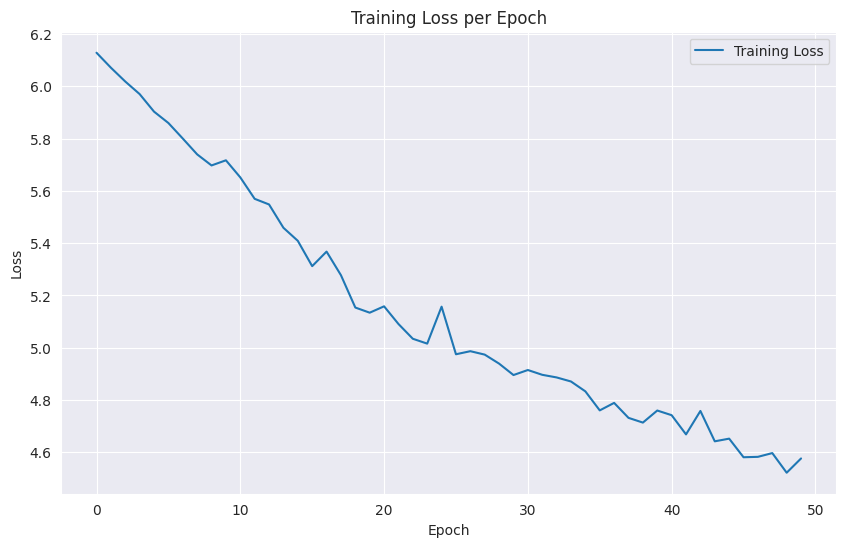

Training history saved to /content/drive/MyDrive/Projects/Car Detection v2/Colab Env/Model History/singleclass_colab_YOLOv8/training_history.json


In [38]:

from torchvision.models.detection.rpn import AnchorGenerator
import torch.optim as optim

# --- Data Loading for Training ---

# Transforms for training data (with data augmentation)
# These should include resizing to 300x300 and converting to tensor
train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToPILImage(), # Convert numpy array to PIL Image
    torchvision.transforms.Resize((300, 300)), # Resize to SSD input size
    torchvision.transforms.ToTensor(), # Convert PIL Image to Tensor (scales to [0, 1])
    # Optional: Add data augmentation like horizontal flip, color jitter, etc.
    # torchvision.transforms.RandomHorizontalFlip(0.5),
    # torchvision.transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
])

# Transforms for validation data (without augmentation, just resizing and tensor conversion)
val_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToPILImage(),
    torchvision.transforms.Resize((300, 300)),
    torchvision.transforms.ToTensor(),
])


# Create Datasets
train_dataset = CustomObjectDetectionDataset(
    img_dir=TRAIN_IMAGES_PATH,
    label_dir=TRAIN_LABELS_PATH,
    transforms=train_transforms
)

valid_dataset = CustomObjectDetectionDataset(
    img_dir=VALID_IMAGES_PATH,
    label_dir=VALID_LABELS_PATH,
    transforms=val_transforms
)

# Collate function for detection datasets
def collate_fn(batch):
    return tuple(zip(*batch))

# Create DataLoaders
train_loader = DataLoader(
    train_dataset,
    batch_size=16, # Adjust batch size based on GPU memory
    shuffle=True,
    num_workers=2, # Adjust based on your system and available RAM/CPU cores
    collate_fn=collate_fn
)

valid_loader = DataLoader(
    valid_dataset,
    batch_size=16,
    shuffle=False, # No need to shuffle validation data
    num_workers=2,
    collate_fn=collate_fn
)

print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(valid_dataset)}")


# --- Optimizer ---
# SGD is commonly used for detection models
params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# Optional: Learning Rate Scheduler (reduces learning rate during training)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)


# --- Training Function ---
def train_one_epoch(model, optimizer, data_loader, device, epoch):
    model.train() # Set model to training mode
    total_loss = 0
    print(f"\nEpoch {epoch}: Training...")
    # Use a progress bar for better visualization (optional)
    # from tqdm.auto import tqdm
    # data_loader = tqdm(data_loader, desc=f"Epoch {epoch}")

    for i, (images, targets, _) in enumerate(data_loader):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Forward pass
        # In training mode, detection models return a dictionary of losses
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        # Backward pass and optimize
        optimizer.zero_grad()
        # Add gradient clipping if needed
        # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.1)
        losses.backward()
        optimizer.step()

        total_loss += losses.item()

        # Print loss every few batches
        if (i + 1) % 10 == 0: # Print every 10 batches
            print(f"  Batch {i+1}/{len(data_loader)}, Loss: {losses.item():.4f}")

    avg_loss = total_loss / len(data_loader)
    print(f"Epoch {epoch} finished. Average Loss: {avg_loss:.4f}")
    return avg_loss

# --- Evaluation Function (Modified for collecting predictions) ---
# This function collects predictions and ground truth for proper evaluation (e.g., mAP)
def evaluate_model(model, data_loader, device):
    model.eval() # Set model to evaluation mode
    # total_loss = 0 # Loss calculation is removed from evaluation
    print("\nEvaluating (Collecting Predictions)...")
    predictions = []
    ground_truths = []

    # Use a progress bar for better visualization (optional)
    # from tqdm.auto import tqdm
    # data_loader = tqdm(data_loader, desc="Evaluating")

    with torch.no_grad(): # No need to calculate gradients during evaluation
        for i, (images, targets, _) in enumerate(data_loader):
            images = list(image.to(device) for image in images)
            # targets = [{k: v.to(device) for k, v in t.items()} for t in targets] # Targets are ground truth

            # Forward pass - in eval mode, model returns a list of dictionaries (predictions)
            outputs = model(images)

            predictions.extend(outputs) # Collect predictions
            ground_truths.extend(targets) # Collect corresponding ground truths

            # # Original loss calculation (removed)
            # loss_dict = model(images, targets) # This will raise error in eval mode
            # losses = sum(loss for loss in loss_dict.values())
            # total_loss += losses.item()

    # avg_loss = total_loss / len(data_loader) # Loss calculation removed
    # print(f"Evaluation finished. Average Loss: {avg_loss:.4f}")

    print(f"Finished collecting predictions and ground truths for {len(predictions)} images.")
    # TODO: Implement mAP calculation here using collected predictions and ground_truths
    # You will need a library like torchmetrics or pycocotools for this.
    # Example using torchmetrics (install with: pip install torchmetrics[detection])
    # from torchmetrics.detection.mean_ap import MeanAveragePrecision
    # metric = MeanAveragePrecision()
    # metric.update(predictions, ground_truths)
    # map_result = metric.compute()
    # print(f"mAP results: {map_result}")

    # Returning None for loss as we are not calculating it here
    return None # Return collected predictions and ground_truths if needed for external mAP calculation

# --- Training Loop ---
num_epochs = 50 # As requested
# Store only training loss, as validation loss calculation is removed
history = {'train_loss': []} #'val_loss': []}

# Create directory for saving model weights if it doesn't exist
model_weights_dir = os.path.join(FULL_EXPERIMENT_PATH, 'weights')
os.makedirs(model_weights_dir, exist_ok=True)

# Removed best_val_loss and saving based on it, as we are not calculating validation loss here.
# best_val_loss = float('inf') # Initialize with a high value

for epoch in range(num_epochs):
    # Train for one epoch
    train_loss = train_one_epoch(model, optimizer, train_loader, device, epoch)
    history['train_loss'].append(train_loss)

    # Evaluate on the validation set (now only collects predictions, does not calculate loss)
    # A proper evaluation (mAP) would be done here after collecting predictions
    # val_loss = evaluate_model(model, valid_loader, device)
    # history['val_loss'].append(val_loss) # Removed adding to history

    # Step the learning rate scheduler (if using one)
    # if lr_scheduler is not None:
    #     lr_scheduler.step()

    # Removed saving the best model based on validation loss

    # Save the latest model state after each epoch
    last_model_path = os.path.join(model_weights_dir, f'epoch_{epoch+1}_last.pt')
    torch.save(model.state_dict(), last_model_path)
    print(f"Saved model after epoch {epoch+1} to {last_model_path}")

# Optional: Save the final model after training
final_model_path = os.path.join(model_weights_dir, 'final.pt')
torch.save(model.state_dict(), final_model_path)
print(f"\nTraining completed! Final model saved to {final_model_path}")


# --- Plot Training History ---
plt.figure(figsize=(10, 6))
plt.plot(history['train_loss'], label='Training Loss')
# plt.plot(history['val_loss'], label='Validation Loss') # Removed plotting validation loss
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss per Epoch') # Updated title
plt.legend()
plt.grid(True)
plt.show()

# You can also save the history
history_path = os.path.join(FULL_EXPERIMENT_PATH, 'training_history.json')
with open(history_path, 'w') as f:
    json.dump(history, f)
print(f"Training history saved to {history_path}")


In [13]:

# --- Video Inference ---

# Define the path to your test video
VIDEO_INPUT_PATH = os.path.join(VIDEO_TEST, 'traffic_test.mp4') # REPLACE with your video file name

# Define the output path for the labeled video
# Ensure the directory exists
os.makedirs(VIDEO_TEST_PREDICTION, exist_ok=True)
VIDEO_OUTPUT_PATH = os.path.join(VIDEO_TEST_PREDICTION, 'ssd with mobilenetv3 backbone.mp4') # Use .avi format for broader compatibility

# Confidence threshold for detections
CONF_THRESHOLD = 0.5 # Adjust based on your trained model's performance
# IOU threshold for Non-Maximum Suppression (NMS)
NMS_THRESHOLD = 0.45 # Common value

# Assuming the model is already trained and loaded on 'device' from previous steps
# If not, load the best weights:
if 'model' not in locals():
    print("Model not found, creating and loading weights...")
    model = create_ssd_mobilenetv3(NUM_CLASSES) # Create the model structure
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    best_weights_path = os.path.join(FULL_EXPERIMENT_PATH, 'weights', 'best.pt')
    if os.path.exists(best_weights_path):
        model.load_state_dict(torch.load(best_weights_path, map_location=device))
        print(f"Loaded best weights from: {best_weights_path}")
    else:
        print(f"WARNING: Best weights not found at {best_weights_path}. Using uninitialized model.")

model.eval() # Set model to evaluation mode

# Open the video file
cap = cv2.VideoCapture(VIDEO_INPUT_PATH)

if not cap.isOpened():
    print(f"Error: Could not open video file {VIDEO_INPUT_PATH}")
else:
    # Get video properties
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    print(f"Reading video: {VIDEO_INPUT_PATH}")
    print(f"Frame Dimensions: {frame_width}x{frame_height}")
    print(f"FPS: {fps}")
    print(f"Total Frames: {total_frames}")


    # Define the codec and create VideoWriter object
    # Use XVID or DIVX codec (might need to install opencv-contrib-python for some codecs)
    # fourcc = cv2.VideoWriter_fourcc(*'XVID')
    fourcc = cv2.VideoWriter_fourcc(*'MJPG') # MJPG is generally well-supported
    out = cv2.VideoWriter(VIDEO_OUTPUT_PATH, fourcc, fps, (frame_width, frame_height))

    if not out.isOpened():
        print(f"Error: Could not create video writer for {VIDEO_OUTPUT_PATH}. Make sure the directory exists and you have write permissions.")
        # Close the capture and return if VideoWriter fails
        cap.release()
    else:
        print(f"Writing labeled video to: {VIDEO_OUTPUT_PATH}")
        frame_count = 0

        # Transforms for inference: Resize to 300x300 and convert to tensor
        inference_transforms = torchvision.transforms.Compose([
            torchvision.transforms.ToPILImage(),
            torchvision.transforms.Resize((300, 300)), # SSD input size
            torchvision.transforms.ToTensor(),
        ])

        # Class names (match the order used during training)
        CLASS_NAMES = ['__background__', 'car'] # Match this to your actual classes

        try:
            while True:
                ret, frame = cap.read()
                if not ret:
                    break # End of video

                frame_count += 1
                # Optional: Print progress
                # print(f"Processing frame {frame_count}/{total_frames}", end='\r')

                # Convert the frame to RGB (OpenCV reads as BGR)
                frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

                # Apply transforms and prepare for model input
                # Transforms expect a PIL Image, so convert the NumPy array
                frame_tensor = inference_transforms(frame_rgb).unsqueeze(0).to(device) # Add batch dimension and move to device

                # Perform inference
                with torch.no_grad():
                    predictions = model(frame_tensor) # model expects a list of tensors

                # Process predictions (the model returns a list of dicts, one for each image in the batch)
                # We only have one image in the batch
                output = predictions[0]

                boxes = output['boxes']
                labels = output['labels']
                scores = output['scores']

                # Filter predictions based on confidence threshold
                keep_indices = torch.where(scores > CONF_THRESHOLD)[0]
                filtered_boxes = boxes[keep_indices]
                filtered_labels = labels[keep_indices]
                filtered_scores = scores[keep_indices]

                # Apply Non-Maximum Suppression (NMS) - torchvision models already apply NMS by default
                # within their internal prediction processing.
                # However, if you want to re-apply with a different threshold or visualize before NMS,
                # you could do it here. For standard usage, the model's output is usually post-NMS.
                # If you were to manually apply NMS:
                # keep_after_nms = torchvision.ops.nms(filtered_boxes, filtered_scores, NMS_THRESHOLD)
                # final_boxes = filtered_boxes[keep_after_nms]
                # final_labels = filtered_labels[keep_after_nms]
                # final_scores = filtered_scores[keep_after_nms]
                # Using the model's default output which is already NMS'd based on its internal threshold

                # Draw bounding boxes and labels on the frame
                # The box coordinates are relative to the 300x300 input, scale them back to original frame size
                scale_x = frame_width / 300
                scale_y = frame_height / 300

                # Convert boxes to numpy and scale
                scaled_boxes = filtered_boxes.cpu().numpy()
                scaled_boxes[:, [0, 2]] *= scale_x # Scale x_min, x_max
                scaled_boxes[:, [1, 3]] *= scale_y # Scale y_min, y_max

                # Convert labels and scores to numpy/list
                final_labels_list = filtered_labels.cpu().numpy().tolist()
                final_scores_list = filtered_scores.cpu().numpy().tolist()

                # Draw on the original BGR frame for OpenCV VideoWriter
                frame_bgr = frame # We draw on the original frame read by cv2

                for i in range(len(scaled_boxes)):
                    box = scaled_boxes[i]
                    label = final_labels_list[i]
                    score = final_scores_list[i]

                    x1, y1, x2, y2 = map(int, box)

                    # Get class name (remember label 0 is background)
                    class_name = CLASS_NAMES[label] if label < len(CLASS_NAMES) else f"Class {label}"

                    # Draw rectangle
                    color = (0, 255, 0) # Green color
                    cv2.rectangle(frame_bgr, (x1, y1), (x2, y2), color, 2)

                    # Put label and score text
                    text = f"{class_name}: {score:.2f}"
                    cv2.putText(frame_bgr, text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

                # Write the frame with detections to the output video
                out.write(frame_bgr)

        finally:
            # Release everything when job is finished
            cap.release()
            out.release()
            print("\nVideo inference finished.")



Reading video: /content/drive/MyDrive/Projects/Car Detection v2/Video Test/traffic_test.mp4
Frame Dimensions: 1280x720
FPS: 30
Total Frames: 5920
Writing labeled video to: /content/drive/MyDrive/Projects/Car Detection v2/Video Test Prediction Colab Env/ssd with mobilenetv3 backbone.mp4

Video inference finished.


In [39]:

# --- Image Inference ---

# Get a list of all image files in the test directory
test_image_files = glob.glob(os.path.join(TEST_IMAGES_DIR, '*.jpg')) + \
                   glob.glob(os.path.join(TEST_IMAGES_DIR, '*.jpeg')) + \
                   glob.glob(os.path.join(TEST_IMAGES_DIR, '*.png'))

if not test_image_files:
    print(f"Error: No image files found in the test directory: {TEST_IMAGES_DIR}")
else:
    # Take 16 random samples
    num_samples = min(16, len(test_image_files))
    random_sample_paths = random.sample(test_image_files, num_samples)

    print(f"Selected {num_samples} random images from {TEST_IMAGES_DIR} for inference.")

    # Confidence threshold for detections
    CONF_THRESHOLD_INFERENCE = 0.5 # Adjust based on your trained model's performance

    # Ensure the model is loaded and on the correct device
    # This assumes the model variable `model` and device variable `device` are already defined
    # and the model is potentially loaded with weights from the training step.
    if 'model' not in locals():
        print("Model not found, creating and loading weights for inference...")
        model = create_ssd_mobilenetv3(NUM_CLASSES) # Create the model structure
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model.to(device)
        # Load the best weights if they exist
        best_weights_path = os.path.join(FULL_EXPERIMENT_PATH, 'weights', 'best.pt')
        if os.path.exists(best_weights_path):
            model.load_state_dict(torch.load(best_weights_path, map_location=device))
            print(f"Loaded best weights from: {best_weights_path}")
        else:
            print(f"WARNING: Best weights not found at {best_weights_path}. Using uninitialized model for inference.")
    else:
        print("Using existing model for inference.")

    model.eval() # Set model to evaluation mode

    # Transforms for inference: Resize to 300x300 and convert to tensor
    inference_transforms = torchvision.transforms.Compose([
        torchvision.transforms.ToPILImage(),
        torchvision.transforms.Resize((300, 300)), # SSD input size
        torchvision.transforms.ToTensor(),
    ])

    # Class names (match the order used during training)
    CLASS_NAMES = ['__background__', 'car'] # Match this to your actual classes

    # Create a grid of plots
    fig, axs = plt.subplots(4, 4, figsize=(16, 16))
    fig.suptitle('Object Detection Inference Results', fontsize=20)

    for i, img_path in enumerate(random_sample_paths):
        # Read the image using OpenCV
        img_bgr = cv2.imread(img_path)
        if img_bgr is None:
            print(f"Warning: Could not read image {img_path}. Skipping.")
            continue

        # Convert to RGB for model input
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        original_h, original_w, _ = img_rgb.shape

        # Apply transforms and prepare for model input
        img_tensor = inference_transforms(img_rgb).unsqueeze(0).to(device) # Add batch dimension and move to device

        # Perform inference
        with torch.no_grad():
            predictions = model(img_tensor) # model expects a list of tensors

        # Process predictions (the model returns a list of dicts, one for each image in the batch)
        # We only have one image in the batch
        output = predictions[0]

        boxes = output['boxes']
        labels = output['labels']
        scores = output['scores']

        # Filter predictions based on confidence threshold
        keep_indices = torch.where(scores > CONF_THRESHOLD_INFERENCE)[0]
        filtered_boxes = boxes[keep_indices]
        filtered_labels = labels[keep_indices]
        filtered_scores = scores[keep_indices]

        # Scale the predicted boxes back to the original image size
        # The box coordinates are relative to the 300x300 input, scale them back
        scale_x = original_w / 300
        scale_y = original_h / 300

        # Convert boxes to numpy and scale
        scaled_boxes = filtered_boxes.cpu().numpy()
        scaled_boxes[:, [0, 2]] *= scale_x # Scale x_min, x_max
        scaled_boxes[:, [1, 3]] *= scale_y # Scale y_min, y_max

        # Convert labels and scores to numpy/list
        final_labels_list = filtered_labels.cpu().numpy().tolist()
        final_scores_list = filtered_scores.cpu().numpy().tolist()

        # Draw bounding boxes and labels on the RGB image for matplotlib display
        annotated_img = img_rgb.copy() # Make a copy to draw on

        for j in range(len(scaled_boxes)):
            box = scaled_boxes[j]
            label = final_labels_list[j]
            score = final_scores_list[j]

            x1, y1, x2, y2 = map(int, box)

            # Get class name (remember label 0 is background)
            class_name = CLASS_NAMES[label] if label < len(CLASS_NAMES) else f"Class {label}"

            # Draw rectangle using OpenCV (on the RGB copy)
            color = (0, 255, 0) # Green color
            cv2.rectangle(annotated_img, (x1, y1), (x2, y2), color, 2)

            # Put label and score text using OpenCV
            text = f"{class_name}: {score:.2f}"
            # Define text position (adjust slightly above the box)
            text_origin = (x1, y1 - 10 if y1 - 10 > 10 else y1 + 10)
            cv2.putText(annotated_img, text, text_origin, cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

        # Plot the annotated image
        ax = axs[i // 4, i % 4]
        ax.imshow(annotated_img)
        ax.set_title(os.path.basename(img_path), fontsize=8)
        ax.axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust layout to make space for suptitle
    plt.show()



Output hidden; open in https://colab.research.google.com to view.

In [15]:
# prompt: I have a video in mp4 file for testing. create code for video inference or labeled video that already predicted from the model ssd with mobilenetv3 backbone

# --- Video Inference ---

# Define the path to your test video
VIDEO_INPUT_PATH = os.path.join(VIDEO_TEST, 'traffic_test.mp4') # REPLACE with your video file name

# Define the output path for the labeled video
# Ensure the directory exists
os.makedirs(VIDEO_TEST_PREDICTION, exist_ok=True)
# Changed to .avi - often more compatible with different codecs
VIDEO_OUTPUT_PATH = os.path.join(VIDEO_TEST_PREDICTION, 'ssd with mobilenetv3 backbone (1).mp4')

# Confidence threshold for detections
CONF_THRESHOLD = 0.5 # Adjust based on your trained model's performance
# IOU threshold for Non-Maximum Suppression (NMS)
# Note: torchvision models typically apply NMS internally.
# This threshold might not be directly used here unless you re-implement NMS.
NMS_THRESHOLD = 0.45 # Common value

# Assuming the model is already trained and loaded on 'device' from previous steps
# If not, load the best weights:
if 'model' not in locals():
    print("Model not found, creating and loading weights...")
    # Ensure NUM_CLASSES is defined (it should be from previous cells)
    if 'NUM_CLASSES' not in locals():
        print("ERROR: NUM_CLASSES not defined. Assuming 2 (car + background).")
        NUM_CLASSES = 2

    model = create_ssd_mobilenetv3(NUM_CLASSES) # Create the model structure
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    best_weights_path = os.path.join(FULL_EXPERIMENT_PATH, 'weights', 'best.pt')
    if os.path.exists(best_weights_path):
        try:
            # Use map_location to load weights correctly regardless of where it was saved
            model.load_state_dict(torch.load(best_weights_path, map_location=device))
            print(f"Loaded best weights from: {best_weights_path}")
        except Exception as e:
             print(f"Error loading model weights from {best_weights_path}: {e}")
             print("Using uninitialized model.")
    else:
        print(f"WARNING: Best weights not found at {best_weights_path}. Using uninitialized model.")

model.eval() # Set model to evaluation mode

# Open the video file
cap = cv2.VideoCapture(VIDEO_INPUT_PATH)

if not cap.isOpened():
    print(f"Error: Could not open video file {VIDEO_INPUT_PATH}")
else:
    # Get video properties
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    # In some cases, total_frames might be -1. Handle this if needed.
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    print(f"Reading video: {VIDEO_INPUT_PATH}")
    print(f"Frame Dimensions: {frame_width}x{frame_height}")
    print(f"FPS: {fps}")
    print(f"Total Frames: {total_frames if total_frames > 0 else 'Unknown'}")


    # Define the codec and create VideoWriter object
    # Use a common codec like MJPG or XVID.
    # 'mp4v' or 'avc1' might also work depending on your OpenCV build and installed codecs.
    # fourcc = cv2.VideoWriter_fourcc(*'XVID')
    # fourcc = cv2.VideoWriter_fourcc(*'DIVX')
    fourcc = cv2.VideoWriter_fourcc(*'MJPG') # MJPG is generally well-supported and produces .avi

    # The output frame size MUST match the frame size read from the input video
    out = cv2.VideoWriter(VIDEO_OUTPUT_PATH, fourcc, fps, (frame_width, frame_height))

    if not out.isOpened():
        print(f"Error: Could not create video writer for {VIDEO_OUTPUT_PATH}.")
        print("Common issues: Invalid codec (fourcc), insufficient permissions, or incorrect path.")
        print("Attempting with a different codec ('mp4v')...")
        try:
             fourcc_mp4v = cv2.VideoWriter_fourcc(*'mp4v')
             out = cv2.VideoWriter(VIDEO_OUTPUT_PATH.replace('.avi', '.mp4'), fourcc_mp4v, fps, (frame_width, frame_height))
             if out.isOpened():
                 VIDEO_OUTPUT_PATH = VIDEO_OUTPUT_PATH.replace('.avi', '.mp4')
                 print(f"Successfully created video writer with 'mp4v' codec: {VIDEO_OUTPUT_PATH}")
             else:
                 print("Second attempt with 'mp4v' also failed. Please check your OpenCV installation and codecs.")
                 # Close the capture and return if VideoWriter fails
                 cap.release()
                 # Ensure 'out' is None or handle appropriately if creation failed
                 out = None # Explicitly set out to None if it failed
        except Exception as e:
            print(f"Error during second attempt with 'mp4v': {e}")
            cap.release()
            out = None
    else:
        print(f"Writing labeled video to: {VIDEO_OUTPUT_PATH}")
        frame_count = 0

        # Transforms for inference: Resize to 300x300 and convert to tensor
        # These transforms are applied BEFORE feeding to the model.
        inference_transforms = torchvision.transforms.Compose([
            torchvision.transforms.ToPILImage(),
            torchvision.transforms.Resize((300, 300)), # SSD input size
            torchvision.transforms.ToTensor(),
        ])

        # Class names (match the order used during training)
        # Ensure this matches your dataset's class mapping.
        CLASS_NAMES = ['__background__', 'car'] # Match this to your actual classes

        # Check if video writer was successfully created before entering the loop
        if out is not None and out.isOpened():
            try:
                while True:
                    ret, frame = cap.read() # frame is a NumPy array, BGR format
                    if not ret:
                        break # End of video

                    frame_count += 1
                    # Optional: Print progress
                    if frame_count % 100 == 0: # Print every 100 frames
                         print(f"Processing frame {frame_count}{'/' + str(total_frames) if total_frames > 0 else ''}", end='\r')


                    # *** IMPORTANT: Create a copy of the frame for drawing ***
                    # This prevents potential issues if the original frame is modified unexpectedly
                    frame_to_draw = frame.copy()

                    # Convert the frame to RGB (needed for the transforms)
                    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

                    # Apply transforms and prepare for model input
                    frame_tensor = inference_transforms(frame_rgb).unsqueeze(0).to(device) # Add batch dimension and move to device

                    # Perform inference
                    with torch.no_grad():
                        # model expects a list of tensors, returns a list of dicts
                        predictions = model(frame_tensor)

                    # Process predictions (the model returns a list of dicts, one for each image in the batch)
                    # We only have one image in the batch
                    output = predictions[0]

                    boxes = output['boxes']
                    labels = output['labels']
                    scores = output['scores']

                    # Filter predictions based on confidence threshold
                    keep_indices = torch.where(scores > CONF_THRESHOLD)[0]
                    filtered_boxes = boxes[keep_indices]
                    filtered_labels = labels[keep_indices]
                    filtered_scores = scores[keep_indices]

                    # --- Drawing Bounding Boxes and Labels ---
                    # The box coordinates are relative to the 300x300 input.
                    # Scale them back to the original frame size before drawing.
                    scale_x = frame_width / 300.0 # Use float division
                    scale_y = frame_height / 300.0

                    # Convert boxes to numpy and scale
                    # Ensure moving to CPU before converting to numpy if on GPU
                    scaled_boxes = filtered_boxes.cpu().numpy()
                    scaled_boxes[:, [0, 2]] *= scale_x # Scale x_min, x_max
                    scaled_boxes[:, [1, 3]] *= scale_y # Scale y_min, y_max

                    # Convert labels and scores to numpy/list
                    final_labels_list = filtered_labels.cpu().numpy().tolist()
                    final_scores_list = filtered_scores.cpu().numpy().tolist()

                    # Draw on the frame_to_draw (which is BGR format, suitable for cv2)
                    for i in range(len(scaled_boxes)):
                        box = scaled_boxes[i]
                        label = final_labels_list[i]
                        score = final_scores_list[i]

                        x1, y1, x2, y2 = map(int, box) # Convert coordinates to integers

                        # Get class name (remember label 0 is background in SSD)
                        # Ensure the label index is valid for CLASS_NAMES
                        class_name = CLASS_NAMES[label] if label >= 0 and label < len(CLASS_NAMES) else f"Unknown Class {label}"

                        # Draw rectangle
                        color = (0, 255, 0) # Green color (BGR format)
                        thickness = 2
                        cv2.rectangle(frame_to_draw, (x1, y1), (x2, y2), color, thickness)

                        # Put label and score text
                        text = f"{class_name}: {score:.2f}"
                        font = cv2.FONT_HERSHEY_SIMPLEX
                        font_scale = 0.6
                        font_thickness = 2
                        # Position the text slightly above the top-left corner of the box
                        text_origin = (x1, y1 - 10 if y1 - 10 > 10 else y1 + 10) # Avoid going out of bounds
                        cv2.putText(frame_to_draw, text, text_origin, font, font_scale, color, font_thickness)

                    # Write the frame with detections to the output video
                    # *** Write the modified frame_to_draw ***
                    out.write(frame_to_draw)

            except Exception as e:
                 print(f"\nAn error occurred during video processing: {e}")
                 # Important: Release resources even if an error occurs
            finally:
                # Release everything when job is finished
                cap.release()
                # Only release 'out' if it was successfully created
                if out is not None and out.isOpened():
                    out.release()
                print("\nVideo inference finished.")
        else:
            print("Video writer was not successfully created. Cannot proceed with processing.")

Reading video: /content/drive/MyDrive/Projects/Car Detection v2/Video Test/traffic_test.mp4
Frame Dimensions: 1280x720
FPS: 30
Total Frames: 5920
Writing labeled video to: /content/drive/MyDrive/Projects/Car Detection v2/Video Test Prediction Colab Env/ssd with mobilenetv3 backbone (1).mp4

Video inference finished.
